In [8]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [9]:
data = pd.read_csv("MotorRPM_time.csv")

In [ ]:
data.head(5)

In [238]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273962 entries, 0 to 273961
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Date      273962 non-null  object 
 1   MotorRPM  273961 non-null  float64
dtypes: float64(1), object(1)
memory usage: 4.2+ MB


In [239]:
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data.sort_index(inplace=True)
data = data.resample('D').mean().fillna(method='ffill')
data['MotorRPM'] = MinMaxScaler().fit_transform(data[['MotorRPM']])
data

,MotorRPM
Date,
2022-08-30,1.000000
2022-08-31,0.444015
2022-09-01,0.411073
2022-09-02,0.411073
2022-09-03,0.411073
...,...
2023-03-16,0.198645
2023-03-17,0.114612
2023-03-18,0.114356


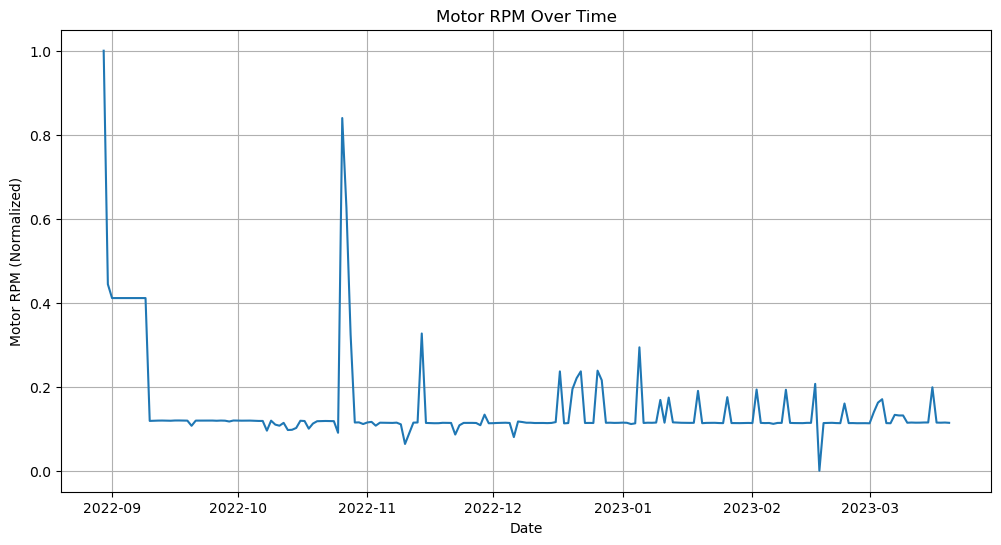

In [240]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(data.index, data['MotorRPM']) 
plt.title('Motor RPM Over Time')
plt.xlabel('Date') 
plt.ylabel('Motor RPM (Normalized)') 
plt.grid(True) 
plt.show() 

In [251]:
num_features = data.shape[1]
print('Number of features:', num_features)

Number of features: 1


In [241]:
# plt.figure(figsize=(10,6))

# # 将日期列转换为datetime格式，以便正确解析
# train['Date'] = pd.to_datetime(test['Date'])

# plt.plot(test['Date'], test['MotorRPM'])
# plt.title('Motor RPM Over Time')
# plt.xlabel('Date')
# plt.ylabel('Motor RPM')
# plt.grid(True)
# plt.show()

In [242]:
# 划分数据集 Split dataset
train_data, test_data = train_test_split(data, test_size=0.2, shuffle=False)
train_tensor = torch.from_numpy(train_data.values.astype(np.float32))
test_tensor = torch.from_numpy(test_data.values.astype(np.float32))

In [243]:
# 创建数据加载器 Creating a data loader
batch_size = 32
train_loader = DataLoader(train_tensor, batch_size=batch_size, shuffle=True)

In [244]:
class Generator(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Generator, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, input_dim),
            nn.ReLU(),
        )

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.model(x)

# 定义损失函数 loss function definition
def fraud_loss(discriminator, real_samples, fake_samples):
    real_loss = nn.BCEWithLogitsLoss()(discriminator(real_samples), torch.ones(real_samples.size(0), 1))
    fake_loss = nn.BCEWithLogitsLoss()(discriminator(fake_samples), torch.zeros_like(fake_samples.size(0), 1))
    return real_loss + fake_loss

def apparent_loss(generator, real_samples):
    fake_samples = generator(real_samples)
    return torch.mean(torch.abs(real_samples-fake_samples))

# 定义优化器 Optimizer Definition
input_dim = 1 # 输入维度
hidden_dim = 100  # 隐藏层维度
generator = Generator(input_dim, hidden_dim)
discriminator = Discriminator(input_dim, hidden_dim)
optimizer_g = optim.Adam(generator.parameters())
optimizer_d = optim.Adam(discriminator.parameters())

In [245]:
print(real_samples.shape)
print(generated_samples.shape)

torch.Size([100, 1])
torch.Size([100, 1])


In [250]:
print(generator) #The achitechure of generator
print(discriminator) ##The achitechure of discriminator

Generator(
  (encoder): Sequential(
    (0): Linear(in_features=1, out_features=100, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
  )
  (decoder): Sequential(
    (0): Linear(in_features=100, out_features=1, bias=True)
    (1): ReLU()
  )
)
Discriminator(
  (model): Sequential(
    (0): Linear(in_features=1, out_features=100, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=100, out_features=1, bias=True)
    (3): Sigmoid()
  )
)


In [254]:
# 训练模型 train the model In this training process, the generator tries to generate 
#as realistic samples as possible to deceive the discriminator, while the discriminator tries to classify the real and generated samples.

n_epochs = 100
for epoch in range(n_epochs):
    for i, real_samples in enumerate(train_loader):
        optimizer_g.zero_grad()
        optimizer_d.zero_grad()
        real_samples_labels = torch.ones((batch_size, 1))
        latent_space_samples = torch.randn((batch_size, hidden_dim))
        generated_samples = generator(latent_space_samples)
        real_samples_predictions = discriminator(real_samples)
        fake_samples_predictions = discriminator(generated_samples)

        real_samples_loss = nn.BCEWithLogitsLoss()(real_samples_predictions, torch.ones_like(real_samples_predictions))
        fake_samples_loss = nn.BCEWithLogitsLoss()(fake_samples_predictions, torch.zeros_like(fake_samples_predictions))

        discriminator_loss = real_samples_loss + fake_samples_loss

        discriminator_loss.backward()
        optimizer_d.step()

        # Train Generator
        optimizer_g.zero_grad()
        latent_space_samples = torch.randn((batch_size, hidden_dim))
        generated_samples = generator(latent_space_samples)

        discriminator_output_on_generated = discriminator(generated_samples)
        generator_loss = apparent_loss(generator, real_samples)
        
        generator_loss.backward()
        optimizer_g.step()

    
    print(f"Epoch {epoch} of {n_epochs}")
    print(f"Generator loss: {generator_loss}")
    print(f"Discriminator loss: {discriminator_loss}")
#         generated_samples_labels = torch.zeros((batch_size, 1))
#         real_samples = real_samples.expand(-1, hidden_dim)
#         all_samples = torch.cat((real_samples, generated_samples))
#         all_samples_labels = torch.cat((real_samples_labels, generated_samples_labels))

#         discriminator_output = discriminator(all_samples)
#         discriminator_loss = fraud_loss(discriminator_output, all_samples_labels)
        
#         discriminator_loss.backward()
#         optimizer_d.step()

#         # 2. 训练 Generator
#         latent_space_samples = torch.randn((batch_size, hidden_dim))
#         generated_samples = generator(latent_space_samples)
#         discriminator_output = discriminator(generated_samples)
#         generator_loss = apparent_loss(generator, real_samples)
#         generator_loss.backward()
#         optimizer_g.step()

#     # 显示损失
#     print(f"Epoch {epoch} of {n_epochs}")
#     print(f"Generator loss: {generator_loss}")
#     print(f"Discriminator loss: {discriminator_loss}")
    

RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x100 and 1x100)

In [256]:
print(real_samples.shape)
print(generated_samples.shape)

torch.Size([32, 1])
torch.Size([32, 1])


In [ ]:
# class generator(nn.Module):
#     def __init__(self,input_size,act_fun,deep=False):
#     super(generator,self).__init__()

#     #deeper neural network or not?
#       if not deep:
#         hidden_size=input_size//2

#         self.encoder_1=nn.Sequential(
#           nn.Linear(input_size,hidden_size),
#           act_fun
#           )

#         self.decoder_1=nn.Sequential(
#           nn.Linear(hidden_size,input_size)
#           )

#         self.encoder_2=nn.Sequential(
#           nn.Linear(input_size,hidden_size),
#           act_fun
#           )
      
#       elif deep:
#         hidden_size_1=input_size//2
#         hidden_size_2=hidden_size_1//2

#         self.encoder_1=nn.Sequential(
#           nn.Linear(input_size,hidden_size_1),
#           act_fun,
#           nn.Linear(hidden_size_1,hidden_size_2),
#           act_fun
#           )

#         self.decoder_1=nn.Sequential(
#           nn.Linear(hidden_size_2,hidden_size_1),
#           act_fun,
#           nn.Linear(hidden_size_1,input_size)
#           )

#         self.encoder_2=nn.Sequential(
#           nn.Linear(input_size,hidden_size_1),
#           act_fun,
#           nn.Linear(hidden_size_1,hidden_size_2),
#           act_fun
#           )

#     def forward(self,input):
#         z=self.encoder_1(input)
#         X_hat=self.decoder_1(z)
#         z_hat=self.encoder_2(X_hat)
#          return z,X_hat,z_hat

In [11]:
# class Encoder(nn.Module):
#     def __init__(self, input_dim, output_dim):
#         super(Encoder, self).__init__()
#         self.conv = nn.Conv1d(input_dim, output_dim, kernel_size=1)
#         self.batch_norm = nn.BatchNorm1d(output_dim)
#         self.leaky_relu = nn.LeakyReLU()

#     def forward(self, x):
#         x = self.conv(x)
#         x = self.batch_norm(x)
#         x = self.leaky_relu(x)
#         return x

# class Decoder(nn.Module):
#     def __init__(self, input_dim, output_dim):
#         super(Decoder, self).__init__()
#         self.convt = nn.ConvTranspose1d(input_dim, output_dim, kernel_size=1)
#         self.batch_norm = nn.BatchNorm1d(output_dim)
#         self.relu = nn.ReLU()

#     def forward(self, x):
#         x = self.convt(x)
#         x = self.batch_norm(x)
#         x = self.relu(x)
#         return x

# class Generator(nn.Module):
#     def __init__(self, input_dim, latent_dim):
#         super(Generator, self).__init__()
#         self.encoder = Encoder(input_dim, latent_dim)
#         self.decoder = Decoder(latent_dim, input_dim)

#     def forward(self, x):
#         z = self.encoder(x)
#         f_hat = self.decoder(z)
#         return f_hat

# class Discriminator(nn.Module):
#     def __init__(self, input_dim, hidden_dim):
#         super(Discriminator, self).__init__()
#         self.disc = nn.Sequential(
#             nn.Conv2d(input_dim, hidden_dim, kernel_size=3, stride=2, padding=1),
#             nn.BatchNorm2d(hidden_dim),
#             nn.LeakyReLU(),
#             # 更多的层...
#             nn.Conv2d(hidden_dim, 1, kernel_size=3, stride=2, padding=1),
#             nn.Sigmoid()
#         )

#     def forward(self, x):
#         return self.disc(x)
    
# generator = Generator(input_dim, latent_dim)
# discriminator = Discriminator(input_dim, hidden_dim)
# input_dim = # 需要根据你的数据设定
# latent_dim = # 需要根据你的模型设定
# hidden_dim = # 需要根据你的模型设定

# def fraud_loss(real_output, fake_output):
#     return nn.BCEWithLogitsLoss()(fake_output, torch.ones_like(fake_output))

# def apparent_loss(real_output, fake_output):
#     return torch.mean(torch.abs(real_output-fake_output))

# def latent_loss(real_output, fake_output):
#     return torch.mean((real_output - fake_output)**2)
    

SyntaxError: invalid syntax (1451764082.py, line 55)